# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris, pollutants_memoris, CONTAMINATION_LEVELS_MEMORIS
from utils.orm import boreholes_from_dataframe
from utils.io import dataframe_viewer
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import re
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

In [3]:
all_pollutants = pollutants_memoris.pollutant
print(all_pollutants)

['arsenic', 'cadmium', 'chrome total', 'chrome vi', 'cobalt', 'cuivre', 'mercure', 'plomb', 'nickel', 'zinc', 'benzene', 'toluene', 'ethylbenzene', 'xylene sum', 'styrene', 'phenol', 'naphtalene', 'acenaphtylene', 'acenaphtene', 'fluorene', 'phenanthrene', 'anthracene', 'fluoranthene', 'pyrene', 'benzo(a)anthracene', 'chrysene', 'benzo(b)fluoranthene', 'benzo(k)fluoranthene', 'benzo(a)pyrene', 'dibenzo(ah)anthracene', 'benzo(ghi)perylene', 'indeno(1.2.3-cd)pyrene', '1.1-dichloroethane', '1.2-dichloroethane', 'cis 1.2 dichloroethene', 'trans 1.2 dichloroethene', 'dichloromethane', '1.2 dichloroethene sum', '1.2-dichloropropane', 'tetrachloroethene', 'tetrachloromethane', '1.1.1-trichloroethane', '1.1.2-trichloroethane', 'trichloroethene', 'trichloromethane (chloroforme)', 'chlorure de vinyle (chloroethene)', 'cyanures libres', 'methyl-tert-butyl-ether', 'fraction 5-8', 'fraction ec 8-10', 'fraction ec 10-12', 'fraction ec 12-16', 'fraction ec 16-21', 'fraction ec 21-35']


## Data Checking

In [4]:
#df[['Pollutant', 'Concentration']] = ''
df.drop(columns=['Pollutant', 'Concentration', 'Unit'], inplace=True)
#df['Concentration'] = df['Concentration'].apply(lambda x: np.random.randint(0,100))
#df['Unit'] = 'mg/l'

In [5]:
pol_lev = ['VR','VS','VI', 'Inconnu']
df[all_pollutants[0:2]] = ''
df[all_pollutants[0]] = df[all_pollutants[0]].apply(lambda x: random.sample(pol_lev, 1)[0])
df[all_pollutants[1]] = df[all_pollutants[1]].apply(lambda x: random.sample(pol_lev, 1)[0])

In [6]:
df['Lithology'] = df['Lithology'].replace({'Grès':'Marne', 'Calcaire':'Dolomie'})

In [7]:
df.loc[35.5, :] = ['BH007',152794.0, 121111.0, 60.0, 0.57, 45, 'Calcaire', 'Bleu', 4, 41, 45, 'VS', 'VR']
df.loc[25.5, :] = ['BH005',152473.0, 121460.0, 72.0, 0.61, 32, 'Schiste', 'gris', 3, 29, 32, 'VI', 'VR']
df.loc[25.6, :] = ['BH005',152473.0, 121460.0, 68.0, 0.61, 36, 'Calcaire', 'Bleu', 4, 32, 36, 'Inconnu', 'VR']

df.drop(index=4, inplace=True)
df.drop(columns='Colour', inplace=True)
df = df.sort_index().reset_index(drop=True)

In [8]:
pollutants = [p for p in all_pollutants if p in df.columns]

In [9]:
dataframe_viewer(df)

Rows : 997, columns : 12


interactive(children=(IntSlider(value=10, description='rows', max=997, min=10, readout=False), IntSlider(value…

## Create Boreholes from dataframes or files

In [10]:
d = {'a':1, 'b':2, 'c':3, 'd':4}
list(d.keys()).index('d')

3

In [11]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(df[:50], verbose=False,
                                                attributes=['Lithology']+pollutants, 
                                                symbols={'lithology':{'lexicon':lexicon_memoris}}, 
                                                diameter='Diameter', thickness='Thickness')


Dataframe processing...

|__ID:'BH001'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'vs'})]
Summary : [Striplog(4 Intervals, start=0.0, stop=28.0)]

|__ID:'BH002'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vr'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'inconnu'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'inconnu'})]
[Component({'lithology': 'dolomie'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vi'}

/home/yanathan/Projects/GSDMA/utils/orm.py:121: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/orm.py:121: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with relatio

In [12]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=28.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=36.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=45.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=11.0, Diameter=0.31, Intervals=3)]

In [13]:
components

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vi'}),
 2: Component({'cadmium': 'vs'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'vs'}),
 5: Component({'lithology': 'marne'}),
 6: Component({'arsenic': 'vr'}),
 7: Component({'lithology': 'charbon'}),
 8: Component({'arsenic': 'inconnu'}),
 9: Component({'cadmium': 'vr'}),
 10: Component({'cadmium': 'inconnu'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'cadmium': 'vi'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

In [14]:
link_intv_comp

{(0, 0): {'extra_data': ''},
 (0, 1): {'extra_data': ''},
 (0, 2): {'extra_data': ''},
 (1, 3): {'extra_data': ''},
 (1, 4): {'extra_data': ''},
 (1, 2): {'extra_data': ''},
 (2, 5): {'extra_data': ''},
 (2, 6): {'extra_data': ''},
 (2, 2): {'extra_data': ''},
 (3, 7): {'extra_data': ''},
 (3, 8): {'extra_data': ''},
 (3, 2): {'extra_data': ''},
 (4, 0): {'extra_data': ''},
 (4, 6): {'extra_data': ''},
 (4, 9): {'extra_data': ''},
 (5, 3): {'extra_data': ''},
 (5, 6): {'extra_data': ''},
 (5, 10): {'extra_data': ''},
 (6, 5): {'extra_data': ''},
 (6, 8): {'extra_data': ''},
 (6, 2): {'extra_data': ''},
 (7, 7): {'extra_data': ''},
 (7, 6): {'extra_data': ''},
 (7, 10): {'extra_data': ''},
 (8, 11): {'extra_data': ''},
 (8, 6): {'extra_data': ''},
 (8, 12): {'extra_data': ''},
 (9, 0): {'extra_data': ''},
 (9, 4): {'extra_data': ''},
 (9, 12): {'extra_data': ''},
 (10, 3): {'extra_data': ''},
 (10, 1): {'extra_data': ''},
 (10, 9): {'extra_data': ''},
 (11, 5): {'extra_data': ''},
 (11,

In [15]:
link_intv_comp[(0, 0)]['extra_data'] = "{'porosite':1, 'densite':1.8}"

In [16]:
len(boreholes), len(components)

(10, 15)

## Create a project and save data in a database

In [17]:
remove('tmp_files/tfe_orm_db.db')

In [18]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [19]:
Base.metadata.create_all(engine)

2021-07-28 16:57:17,111 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-28 16:57:17,112 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-07-28 16:57:17,113 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-28 16:57:17,114 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-07-28 16:57:17,114 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-28 16:57:17,115 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-07-28 16:57:17,116 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-28 16:57:17,117 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-07-28 16:57:17,117 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-28 16:57:17,118 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Components")
2021-07-28 16:57:17,119 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-28 16:57:17,120 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Components")
2021-07-28 16:57:17,120 INFO sqlalchemy.engine.Engin

In [20]:
Session = sessionmaker(bind=engine)
session = Session()

## Define project legend(s) and default attribute for representation

In [21]:
leg_dict = {**{'lithology':{'legend':lithology_memoris}},**{k:{'legend':None} for k in pollutants}}

In [22]:
p = Project(session, lexicon=lexicon_memoris, repr_attribute='lithology', legend_dict=leg_dict)

2021-07-28 16:57:17,172 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-28 16:57:17,175 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-28 16:57:17,176 INFO sqlalchemy.engine.Engine [generated in 0.00117s] ()


In [23]:
p.legend_dict.keys()

dict_keys(['lithology', 'arsenic', 'cadmium'])

In [24]:
p.add_components(components)

2021-07-28 16:57:17,187 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-07-28 16:57:17,188 INFO sqlalchemy.engine.Engine [generated in 0.00113s] ((0, 'Sable'), (1, 'Vi'), (2, 'Vs'), (3, 'Argile'), (4, 'Vs'), (5, 'Marne'), (6, 'Vr'), (7, 'Charbon')  ... displaying 10 of 15 total bound parameter sets ...  (13, 'Schiste'), (14, 'Calcaire'))
2021-07-28 16:57:17,189 INFO sqlalchemy.engine.Engine COMMIT
2021-07-28 16:57:17,192 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-28 16:57:17,193 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-28 16:57:17,193 INFO sqlalchemy.engine.Engine [cached since 0.01878s ago] ()


In [25]:
p.__components_dict__

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vi'}),
 2: Component({'cadmium': 'vs'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'vs'}),
 5: Component({'lithology': 'marne'}),
 6: Component({'arsenic': 'vr'}),
 7: Component({'lithology': 'charbon'}),
 8: Component({'arsenic': 'inconnu'}),
 9: Component({'cadmium': 'vr'}),
 10: Component({'cadmium': 'inconnu'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'cadmium': 'vi'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

Add boreholes into the project

In [26]:
for bh in boreholes:
    p.add_borehole(bh)

2021-07-28 16:57:17,205 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-28 16:57:17,207 INFO sqlalchemy.engine.Engine [generated in 0.00201s] ('BH001', 28.0, 0.43)
2021-07-28 16:57:17,209 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-07-28 16:57:17,209 INFO sqlalchemy.engine.Engine [generated in 0.00058s] ((0, 101.0, 101.0, 101.0, 152600.0, 121039.0), (1, 97.0, 97.0, 97.0, 152600.0, 121039.0), (2, 97.0, 97.0, 97.0, 152600.0, 121039.0), (3, 93.0, 93.0, 93.0, 152600.0, 121039.0), (4, 93.0, 93.0, 93.0, 152600.0, 121039.0), (5, 81.0, 81.0, 81.0, 152600.0, 121039.0), (6, 81.0, 81.0, 81.0, 152600.0, 121039.0), (7, 73.0, 73.0, 73.0, 152600.0, 121039.0))
2021-07-28 16:57:17,212 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-28 16:57:17,213 INFO sqlalchemy.e

2021-07-28 16:57:17,269 INFO sqlalchemy.engine.Engine [cached since 0.047s ago] ('BH002',)
2021-07-28 16:57:17,271 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,271 INFO sqlalchemy.engine.Engine [cached since 0.04549s ago] (8,)
2021-07-28 16:57:17,273 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,273 INFO sqlalchemy.engine.Engine [cached since 0.04497s ago] (9,)
2021-07-28 16:57:17,275 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-07-28 16:57:17,323 INFO sqlalchemy.engine.Engine [cached since 0.09773s ago] (20,)
2021-07-28 16:57:17,325 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,326 INFO sqlalchemy.engine.Engine [cached since 0.09772s ago] (21,)
2021-07-28 16:57:17,328 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,329 INFO sqlalchemy.engine.Engine [cached since 0.103s ago] (22,)
2021-07-28 16:57:17,331 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

2021-07-28 16:57:17,394 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,394 INFO sqlalchemy.engine.Engine [cached since 0.1687s ago] (34,)
2021-07-28 16:57:17,396 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,397 INFO sqlalchemy.engine.Engine [cached since 0.1685s ago] (35,)
2021-07-28 16:57:17,399 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-07-28 16:57:17,460 INFO sqlalchemy.engine.Engine [cached since 0.2345s ago] (46,)
2021-07-28 16:57:17,462 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,463 INFO sqlalchemy.engine.Engine [cached since 0.2343s ago] (47,)
2021-07-28 16:57:17,465 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,466 INFO sqlalchemy.engine.Engine [cached since 0.24s ago] (48,)
2021-07-28 16:57:17,467 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-07-28 16:57:17,524 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,525 INFO sqlalchemy.engine.Engine [cached since 0.2992s ago] (60,)
2021-07-28 16:57:17,526 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,528 INFO sqlalchemy.engine.Engine [cached since 0.2993s ago] (61,)
Borehole geometry created successfully !
2021-07-28 16:57:17,539 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-28 16:57:17,540 IN

2021-07-28 16:57:17,576 INFO sqlalchemy.engine.Engine [cached since 0.3501s ago] (72,)
2021-07-28 16:57:17,577 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,578 INFO sqlalchemy.engine.Engine [cached since 0.3499s ago] (73,)
Borehole geometry created successfully !
2021-07-28 16:57:17,593 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-28 16:57:17,593 INFO sqlalchemy.engine.Engine [cached since 0.3428s ago] (97.0, 'BH007')
2021-07-28 16:57:17,594 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-28 16:57:17,595 INFO sqlalchemy.engine.Engine [cached since 0.3901s ago] ('BH008', 35.0, 0.39)
2021-07-28 16:57:17,596 INFO sql

2021-07-28 16:57:17,639 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-28 16:57:17,639 INFO sqlalchemy.engine.Engine [cached since 0.4271s ago] ((42, 'BH009', 0, '{"lithology": "sable"}, {"arsenic": "vi"}, {"cadmium": "inconnu"}', 84, 85, None), (43, 'BH009', 1, '{"lithology": "argile"}, {"arsenic": "vs"}, {"cadmium": "vs"}', 86, 87, None), (44, 'BH009', 2, '{"lithology": "marne"}, {"arsenic": "inconnu"}, {"cadmium": "vs"}', 88, 89, None), (45, 'BH009', 3, '{"lithology": "charbon"}, {"arsenic": "inconnu"}, {"cadmium": "vs"}', 90, 91, None), (46, 'BH009', 4, '{"lithology": "dolomie"}, {"arsenic": "vs"}, {"cadmium": "vs"}', 92, 93, None))
2021-07-28 16:57:17,640 INFO sqlalchemy.engine.Engine COMMIT
2021-07-28 16:57:17,644 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-28 16:57:17,645 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".l

2021-07-28 16:57:17,707 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,708 INFO sqlalchemy.engine.Engine [cached since 0.4822s ago] (94,)
2021-07-28 16:57:17,709 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-28 16:57:17,711 INFO sqlalchemy.engine.Engine [cached since 0.4824s ago] (95,)
2021-07-28 16:57:17,712 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

In [27]:
p.boreholes_3d[0].name, p.boreholes_3d[0].components

('BH001',
 {0: [Component({'lithology': 'sable'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'v'})],
  1: [Component({'lithology': 'argile'}),
   Component({'arsenic': 'v'}),
   Component({'cadmium': 'v'})],
  2: [Component({'lithology': 'marne'}),
   Component({'arsenic': 'vr'}),
   Component({'cadmium': 'v'})],
  3: [Component({'lithology': 'charbon'}),
   Component({'arsenic': 'inconnu'}),
   Component({'cadmium': 'v'})]})

In [28]:
p.boreholes_orm

2021-07-28 16:57:17,745 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-28 16:57:17,747 INFO sqlalchemy.engine.Engine [cached since 0.4965s ago] (95.0, 'BH10')
2021-07-28 16:57:17,749 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-28 16:57:17,749 INFO sqlalchemy.engine.Engine [cached since 0.5273s ago] ('BH001',)
2021-07-28 16:57:17,751 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_

[<core.orm.BoreholeOrm>(Name=BH001, Length=97.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=98.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=100.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=96.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=97.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=100.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=97.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=98.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=94.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=95.0, Diameter=0.31, Intervals=3)]

In [29]:
p.add_link_components_intervals(link_intv_comp)

2021-07-28 16:57:17,779 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-07-28 16:57:17,781 INFO sqlalchemy.engine.Engine [generated in 0.00199s] ((0, 0, "{'porosite':1, 'densite':1.8}"), (0, 1, ''), (0, 2, ''), (1, 3, ''), (1, 4, ''), (1, 2, ''), (2, 5, ''), (2, 6, '')  ... displaying 10 of 150 total bound parameter sets ...  (49, 1, ''), (49, 2, ''))
2021-07-28 16:57:17,784 INFO sqlalchemy.engine.Engine COMMIT
2021-07-28 16:57:17,788 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-28 16:57:17,789 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-28 16:57:17,790 INFO sqlalchemy.engine.Engine [cached since 0.6149s ago] ()


In [30]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes_orm))

2021-07-28 16:57:17,796 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  10


In [31]:
p.boreholes_orm[2].intervals

2021-07-28 16:57:17,805 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-28 16:57:17,807 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-07-28 16:57:17,808 INFO sqlalchemy.engine.Engine [generated in 0.00111s] ('BH003',)
2021-07-28 16:57:17,810 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-28 16:57:17,811 INFO sqlalchemy.engine.Engine [cached since 0.5888s ago] ('BH003',)
2021-07-28 16:57:17,814 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

{9: <core.orm.IntervalOrm>(Id=9, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7fe5f41ee4c0>Description={"lithology": "sable"}, {"arsenic": "vs"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=0, Description=Sable), <core.orm.ComponentOrm>(Id=4, Description=Vs), <core.orm.ComponentOrm>(Id=12, Description=Vi)]),
 10: <core.orm.IntervalOrm>(Id=10, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7fe60b823580>Description={"lithology": "argile"}, {"arsenic": "vi"}, {"cadmium": "vr"}, Components=[<core.orm.ComponentOrm>(Id=1, Description=Vi), <core.orm.ComponentOrm>(Id=3, Description=Argile), <core.orm.ComponentOrm>(Id=9, Description=Vr)]),
 11: <core.orm.IntervalOrm>(Id=11, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7fe5f41cfd30>Description={"lithology": "marne"}, {"arsenic": "vr"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=5, Description=Marne), <core.orm.ComponentOrm>(Id=6, Description=Vr), <core.orm.ComponentOrm>(Id=12, Description=Vi)

In [32]:
p.refresh(verbose=False)

2021-07-28 16:57:17,844 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-28 16:57:17,845 INFO sqlalchemy.engine.Engine [cached since 0.6707s ago] ()


In [33]:
eval(Component({'lithology':'sable'}).json())

{'lithology': 'sable'}

# 2D/3D Display

### 2D Plot

In [34]:
p.plot2d()

### 3D plot

In [35]:
attributes = list(p.legend_dict.keys())
attributes

['lithology', 'arsenic', 'cadmium']

In [36]:
p.update_legend_cmap(update_all_attrib=True)

({'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
   Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
   Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
   Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
   Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
   Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
   Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
   'cmap': <matplotlib.colors.ListedColormap at 0x7fe5f41c3b50>,
   'values': ['sable',
    'argile',
    'marne',
    'charbon',
    'dolomie',
    'schiste',
    'calcaire']},
  'arsenic': {'l

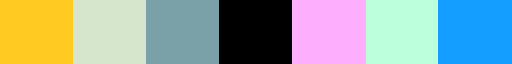

In [37]:
p.legend_dict[attributes[0]]['cmap']

In [38]:
p.legend_dict[attributes[0]]['values']

['sable', 'argile', 'marne', 'charbon', 'dolomie', 'schiste', 'calcaire']

## Display one object (attribute = 'lithology')

In [39]:
bh = 6
p.boreholes_3d[bh].components

{0: [Component({'lithology': 'sable'}),
  Component({'arsenic': 'v'}),
  Component({'cadmium': 'v'})],
 1: [Component({'lithology': 'argile'}),
  Component({'arsenic': 'inconnu'}),
  Component({'cadmium': 'vi'})],
 2: [Component({'lithology': 'marne'}),
  Component({'arsenic': 'inconnu'}),
  Component({'cadmium': 'vi'})],
 3: [Component({'lithology': 'charbon'}),
  Component({'arsenic': 'v'}),
  Component({'cadmium': 'vr'})],
 4: [Component({'lithology': 'dolomie'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'inconnu'})],
 5: [Component({'lithology': 'calcaire'}),
  Component({'arsenic': 'v'}),
  Component({'cadmium': 'vr'})]}

/home/yanathan/Projects/GSDMA/utils/visual.py:424: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:424: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

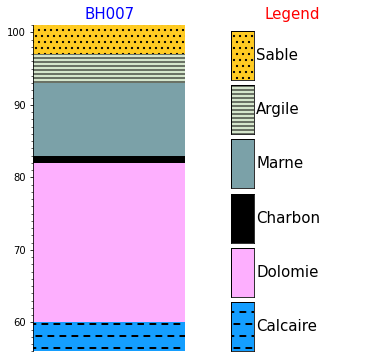

In [40]:
p.boreholes_3d[bh].log_plot()

In [41]:
sargs = dict(title='Test_legend', title_font_size=30, label_font_size=12, n_labels=0,
             fmt="%.2f", font_family="arial", color='k',interactive=True, 
             vertical=True, italic=True, shadow=False,)

In [42]:
p.boreholes_3d[bh].plot3d(custom_legend=False, scalar_bar_args=sargs)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Plot with another attribute

/home/yanathan/Projects/GSDMA/utils/visual.py:424: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:424: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

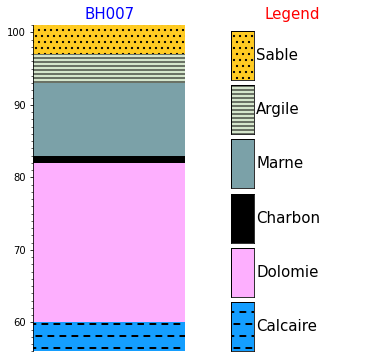

In [43]:
at = 0
p.boreholes_3d[bh].log_plot(repr_attribute=attributes[at])

In [44]:
p.boreholes_3d[bh].plot3d(repr_attribute=attributes[at])

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [45]:
p.boreholes_orm[0].intervals_values

2021-07-28 16:57:19,235 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-28 16:57:19,237 INFO sqlalchemy.engine.Engine [cached since 2.015s ago] ('BH001',)


{0: '{"lithology": "sable"}, {"arsenic": "vi"}, {"cadmium": "vs"}', 1: '{"lithology": "argile"}, {"arsenic": "vs"}, {"cadmium": "vs"}', 2: '{"lithology": "marne"}, {"arsenic": "vr"}, {"cadmium": "vs"}', 3: '{"lithology": "charbon"}, {"arsenic": "inconnu"}, {"cadmium": "vs"}'}

In [46]:
p.boreholes_3d[bh].intervals[0]

Interval({'top': Position({'middle': 101.0, 'x': 152794.0, 'y': 121111.0, 'units': 'm'}), 'base': Position({'middle': 97.0, 'x': 152794.0, 'y': 121111.0, 'units': 'm'}), 'description': '{"lithology": "sable"}, {"arsenic": "vs"}, {"cadmium": "vs"}', 'data': {}, 'components': [Component({'lithology': 'sable'}), Component({'arsenic': 'v'}), Component({'cadmium': 'v'})]})

### Display project boreholes

In [47]:
bh3d_vtk = p.boreholes_3d[bh]._vtk
bh3d_vtk

PolyData (0x7fe5f425be20)
  N Cells:	312
  N Points:	1200
  X Bounds:	1.528e+05, 1.528e+05
  Y Bounds:	1.211e+05, 1.211e+05
  Z Bounds:	5.600e+01, 1.010e+02
  N Arrays:	6

In [48]:
at = 0
p.plot3d(repr_attribute=attributes[at],  bg_color=["royalblue", "aliceblue"], 
                      window_size=(800, 500))

2021-07-28 16:57:19.281 (   3.080s) [        54190740]vtkDataSetAttributes.cx:1296  WARN| vtkPointData (0x39623f0): Can not set attribute Scalars. Only vtkDataArray subclasses can be set as active attributes.


### Boreholes in 3D using X3D for interaction within the notebook

In [56]:
type(p.boreholes_3d[0].omf_legend)

omf.data.Legend